<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [109]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [110]:
# create validation data
x_val = x_train[-10000:, :, :]
x_train = x_train[:-10000, :, :]

y_val = y_train[-10000:]
y_train = y_train[:-10000]

In [111]:
# mirror train image
x_train_add = np.rot90(x_train, k=1, axes=(1,2))
x_train_add = np.transpose(x_train_add, (0, 2, 1))

In [112]:
y_train_add = y_train.copy()

In [113]:
# remove boots image from addition data [5, 7, 9]
for i in [5, 7, 9]:
    index = np.where(y_train_add == i )
    x_train_add = np.delete(x_train_add, index , axis=0)
    y_train_add = np.delete(y_train_add, index , axis=0)

In [114]:
x_train_add.shape

(34972, 28, 28)

In [115]:
y_train_add.shape

(34972,)

In [116]:
x_train = np.concatenate([
    x_train,
    x_train_add
])

In [117]:
y_train = np.concatenate([
    y_train,
    y_train_add
])

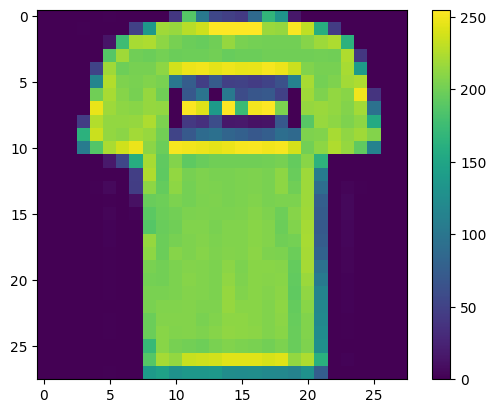

In [118]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.grid(False)
plt.show()

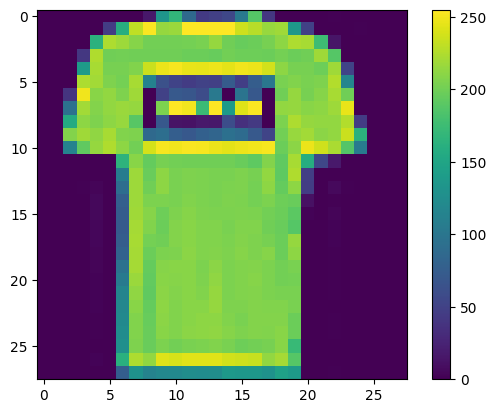

In [119]:
plt.figure()
plt.imshow(x_train_add[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [120]:
y_train[0]

9

In [121]:
y_train[50002]

3

In [122]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_val.astype('float32') / 255
y_val = y_val.astype('float32')

In [123]:
w_init_tanh = initializers.glorot_normal(seed=111)
# w_init_relu = initializers.HeNormal(seed=66)
w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

In [124]:
drop_out = 0.33

In [125]:
def layer_relu(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [126]:
def layer_tanh(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [127]:
model = tf.keras.Sequential()

neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model = layer_relu(model, neurons*1)
model = layer_relu(model, neurons*2)
model = layer_relu(model, neurons*2)
# model = layer_relu(model, neurons*1)


model.add(layers.Dense(10, activation='softmax'))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [128]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001,
                                      beta_1=0.92,
                                      beta_2=0.999,
                                      epsilon=1e-04
)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [129]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 120ms/step


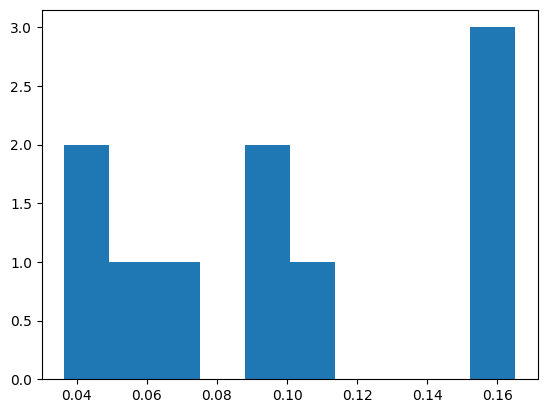

In [130]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [131]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [132]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=60)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='accuracy', mode='max', verbose=0, save_best_only=True)


In [133]:
history = model.fit(x_train, y_train,
                    epochs=660,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc, es],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/660
664/664 [==============================] - 32s 38ms/step - loss: 0.6729 - accuracy: 0.7578 - val_loss: 0.4014 - val_accuracy: 0.8517
Epoch 2/660
664/664 [==============================] - 16s 24ms/step - loss: 0.4894 - accuracy: 0.8175 - val_loss: 0.3742 - val_accuracy: 0.8624
Epoch 3/660
664/664 [==============================] - 15s 23ms/step - loss: 0.4513 - accuracy: 0.8307 - val_loss: 0.3548 - val_accuracy: 0.8700
Epoch 4/660
664/664 [==============================] - 15s 23ms/step - loss: 0.4273 - accuracy: 0.8404 - val_loss: 0.3468 - val_accuracy: 0.8684
Epoch 5/660
664/664 [==============================] - 16s 24ms/step - loss: 0.4114 - accuracy: 0.8449 - val_loss: 0.3261 - val_accuracy: 0.8800
Epoch 6/660
664/664 [==============================] - 16s 24ms/step - loss: 0.3964 - accuracy: 0.8516 - val_loss: 0.3230 - val_accuracy: 0.8811
Epoch 7/660
664/664 [==============================] - 15s 23ms/step - loss: 0.3859 - accuracy: 0.8556 - val_loss: 0.3140 - val_ac

In [134]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


In [135]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 2s 5ms/step - loss: 0.2940 - accuracy: 0.9026
[0.29402387142181396, 0.9025999903678894]


In [136]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.3032 - accuracy: 0.9002
[0.30315443873405457, 0.9002000093460083]


In [137]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

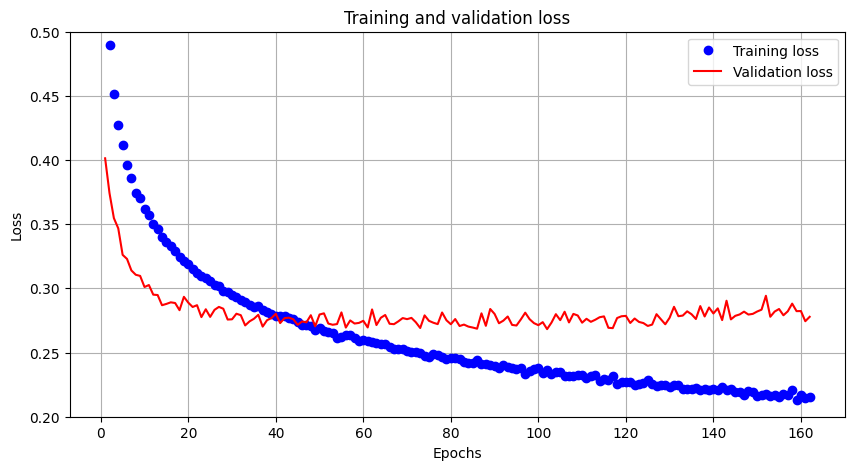

<Figure size 640x480 with 0 Axes>

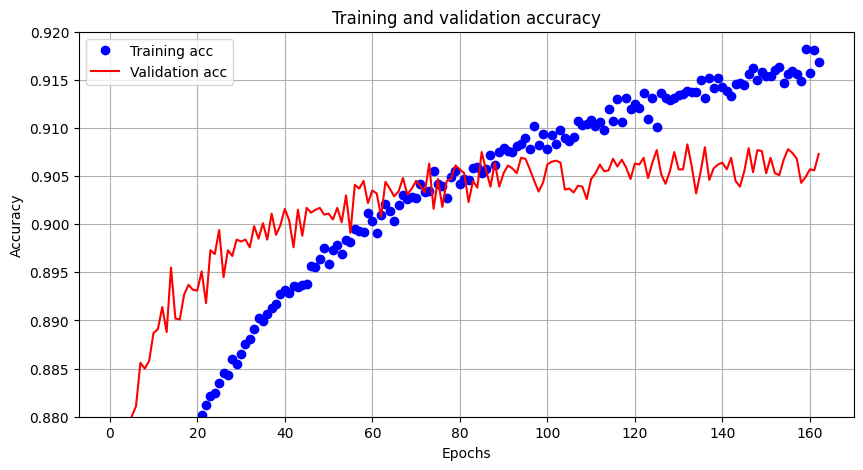

In [138]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.92)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [139]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [140]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 2s 4ms/step


In [141]:
predictions[0]

array([0.08537816, 0.08537816, 0.08537816, 0.08537816, 0.08537816,
       0.0853837 , 0.08537816, 0.08565664, 0.08537816, 0.23131241],
      dtype=float32)

In [142]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dropout_8 (Dropout)         (None, 784)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 784)               3136      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [143]:




hnyetjn hrte()

SyntaxError: invalid syntax (<ipython-input-143-1a3818e70946>, line 1)